In [1]:
from jax import numpy as np
from jax import random
import jax
import pennylane as qml
import optax

## UCC

In [ ]:
jax.config.update("jax_platform_name", "cpu")
jax.config.update('jax_enable_x64', True)


dataset = qml.data.load('qchem', molname="H2")[0]
H, qubits = dataset.hamiltonian, len(dataset.hamiltonian.wires)
print("Number of qubits = ", qubits)
print("The Hamiltonian is ", H)

Number of qubits =  4
The Hamiltonian is  -0.09963387941370971 * I(0) + 0.17110545123720233 * Z(0) + 0.17110545123720225 * Z(1) + 0.16859349595532533 * (Z(0) @ Z(1)) + 0.04533062254573469 * (Y(0) @ X(1) @ X(2) @ Y(3)) + -0.04533062254573469 * (Y(0) @ Y(1) @ X(2) @ X(3)) + -0.04533062254573469 * (X(0) @ X(1) @ Y(2) @ Y(3)) + 0.04533062254573469 * (X(0) @ Y(1) @ Y(2) @ X(3)) + -0.22250914236600539 * Z(2) + 0.12051027989546245 * (Z(0) @ Z(2)) + -0.22250914236600539 * Z(3) + 0.16584090244119712 * (Z(0) @ Z(3)) + 0.16584090244119712 * (Z(1) @ Z(2)) + 0.12051027989546245 * (Z(1) @ Z(3)) + 0.1743207725924201 * (Z(2) @ Z(3))


In [3]:
dev = qml.device("lightning.qubit", wires=qubits)

In [4]:
electrons = 2
hf = qml.qchem.hf_state(electrons, qubits)
print(hf)

[1 1 0 0]


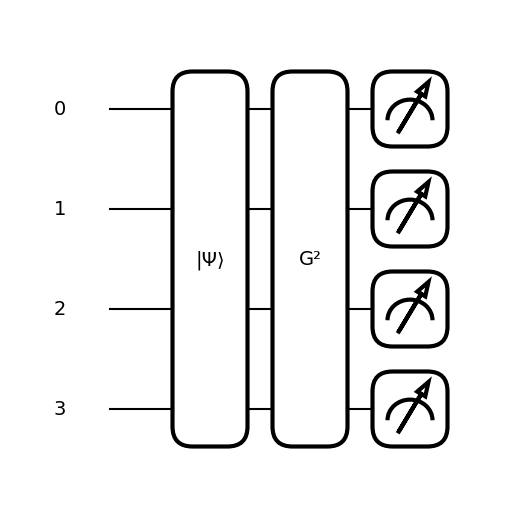

In [46]:
@qml.qnode(dev, interface="jax")
def circuit(param, wires):
    qml.BasisState(hf, wires=wires)
    qml.DoubleExcitation(param, wires=[0, 1, 2, 3])
    return qml.expval(H)
fig, ax = qml.draw_mpl(circuit,expansion_strategy="device",style="black_white")(np.pi, range(qubits))

In [11]:
def cost_fn(param):
    return circuit(param, wires=range(qubits))

In [12]:
max_iterations = 100
conv_tol = 1e-06

opt = optax.sgd(learning_rate=0.4)

In [42]:
key = random.PRNGKey(4)

In [47]:
theta = np.array(0.)

# store the values of the cost function
energy = [cost_fn(theta)]

# store the values of the circuit parameter
angle = [theta]

opt_state = opt.init(theta)

for n in range(max_iterations):

    gradient = jax.grad(cost_fn)(theta)
    updates, opt_state = opt.update(gradient, opt_state)
    theta = optax.apply_updates(theta, updates)
    
    angle.append(theta)
    energy.append(cost_fn(theta))

    conv = np.abs(energy[-1] - energy[-2])

    if n % 2 == 0:
        print(f"Step = {n},  Energy = {energy[-1]:.8f} Ha")

    if conv <= conv_tol:
        break

print("\n" f"Final value of the ground-state energy = {energy[-1]:.8f} Ha")
print("\n" f"Optimal value of the circuit parameter = {angle[-1]:.4f}")

Step = 0,  Energy = -1.12772109 Ha
Step = 2,  Energy = -1.13524628 Ha
Step = 4,  Energy = -1.13683932 Ha
Step = 6,  Energy = -1.13717430 Ha
Step = 8,  Energy = -1.13724463 Ha
Step = 10,  Energy = -1.13725940 Ha
Step = 12,  Energy = -1.13726250 Ha

Final value of the ground-state energy = -1.13726250 Ha

Optimal value of the circuit parameter = 0.2250


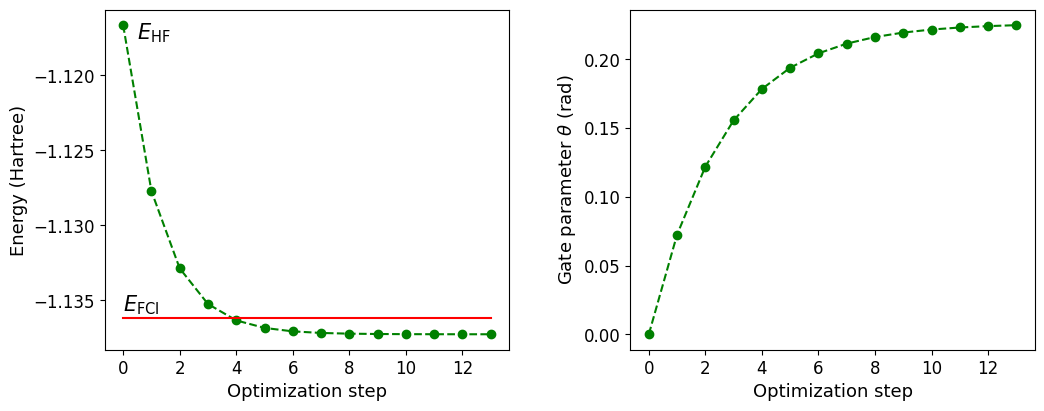

In [48]:
import matplotlib.pyplot as plt

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(12)

# Full configuration interaction (FCI) energy computed classically
E_fci = -1.136189454088

# Add energy plot on column 1
ax1 = fig.add_subplot(121)
ax1.plot(range(n + 2), energy, "go", ls="dashed")
ax1.plot(range(n + 2), np.full(n + 2, E_fci), color="red")
ax1.set_xlabel("Optimization step", fontsize=13)
ax1.set_ylabel("Energy (Hartree)", fontsize=13)
ax1.text(0.5, -1.1176, r"$E_\mathrm{HF}$", fontsize=15)
ax1.text(0, -1.1357, r"$E_\mathrm{FCI}$", fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add angle plot on column 2
ax2 = fig.add_subplot(122)
ax2.plot(range(n + 2), angle, "go", ls="dashed")
ax2.set_xlabel("Optimization step", fontsize=13)
ax2.set_ylabel("Gate parameter $\\theta$ (rad)", fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplots_adjust(wspace=0.3, bottom=0.2)
plt.show()

## Hardware efficient ansatz

In [ ]:
import pennylane as qml
from pennylane import numpy as np

# 1. DEFINE THE MOLECULE AND GET THE HAMILTONIAN
# We'll use PennyLane's built-in tools to get the H2 Hamiltonian.
# This part is the same as in the example you provided.
dataset = qml.data.load('qchem', molname="H2")[0]
H, qubits = dataset.hamiltonian, len(dataset.hamiltonian.wires)

print(f"Number of qubits required: {qubits}")
print("Hamiltonian:", H)

# 2. SET UP THE DEVICE
# We'll use PennyLane's default simulator.
dev = qml.device("default.qubit", wires=qubits)

# 3. DESIGN THE HARDWARE-EFFICIENT ANSATZ
# A hardware-efficient ansatz consists of layers of rotations and entanglements.
# - Rotations: Apply a rotation gate (like RY) to each qubit.
# - Entanglements: Apply CNOT gates between adjacent qubits.
def hardware_efficient_ansatz(params, wires):
    """
    A simple hardware-efficient ansatz.

    Args:
        params (array): A 2D array of parameters with shape (num_layers, num_qubits).
        wires (list): The list of wires to apply the ansatz on.
    """
    num_layers = params.shape[0]
    num_qubits = len(wires)

    for layer in range(num_layers):
        # Layer of rotation gates
        for i in range(num_qubits):
            qml.U3(params[layer, i, 0], params[layer, i, 1], params[layer, i, 2], wires=i)

        # Layer of entangling gates
        for i in range(num_qubits - 1):
            qml.CNOT(wires=[i, i + 1])

# 4. DEFINE THE VQE QNODE (QUANTUM CIRCUIT)
# This QNode will apply our ansatz and then measure the
# expectation value of the Hamiltonian.
@qml.qnode(dev)
def cost_function(params):
    hardware_efficient_ansatz(params, wires=range(qubits))
    return qml.expval(H)

# 5. SET UP AND RUN THE OPTIMIZATION
# We'll use the Adam optimizer to find the best parameters for our ansatz.

# Define the number of layers in our ansatz
num_layers = 50
# Initialize random parameters for the ansatz
# Shape is (num_layers, num_qubits)
params = np.random.uniform(0, 2 * np.pi, (num_layers, qubits), requires_grad=True)

# Set up the optimizer
optimizer = qml.AdamOptimizer(stepsize=0.1)

# Optimization settings
max_iterations = 1000
conv_tolerance = 1e-6
cost_history = []

print("\nStarting VQE optimization...")

for n in range(max_iterations):
    # Perform one optimization step
    params, cost = optimizer.step_and_cost(cost_function, params)
    cost_history.append(cost)
    # Print the energy at regular intervals
    if n % 10 == 0:
        print(f"Iteration = {n}, Energy = {cost:.8f} Ha")

    # Check for convergence
    if n > 0 and np.abs(cost_history[-1] - cost_history[-2]) <= conv_tolerance:
        print("\nConvergence reached!")
        break

# 6. PRINT THE FINAL RESULTS
# The exact ground state energy for H2 at this bond length is -1.13618945 Ha.
# Let's see how close we got.
print("\n--- VQE Results ---")
print(f"Final ground state energy = {cost:.8f} Ha")
print(f"Optimal parameters shape: {params.shape}")

Number of qubits required: 4
Hamiltonian: -0.09963387941370971 * I(0) + 0.17110545123720233 * Z(0) + 0.17110545123720225 * Z(1) + 0.16859349595532533 * (Z(0) @ Z(1)) + 0.04533062254573469 * (Y(0) @ X(1) @ X(2) @ Y(3)) + -0.04533062254573469 * (Y(0) @ Y(1) @ X(2) @ X(3)) + -0.04533062254573469 * (X(0) @ X(1) @ Y(2) @ Y(3)) + 0.04533062254573469 * (X(0) @ Y(1) @ Y(2) @ X(3)) + -0.22250914236600539 * Z(2) + 0.12051027989546245 * (Z(0) @ Z(2)) + -0.22250914236600539 * Z(3) + 0.16584090244119712 * (Z(0) @ Z(3)) + 0.16584090244119712 * (Z(1) @ Z(2)) + 0.12051027989546245 * (Z(1) @ Z(3)) + 0.1743207725924201 * (Z(2) @ Z(3))

Starting VQE optimization...
Iteration = 0, Energy = 0.04127702 Ha
Iteration = 10, Energy = -0.78685550 Ha
Iteration = 20, Energy = -1.06785373 Ha
Iteration = 30, Energy = -1.10907416 Ha
Iteration = 40, Energy = -1.12156715 Ha
Iteration = 50, Energy = -1.13353218 Ha
Iteration = 60, Energy = -1.13598526 Ha
Iteration = 70, Energy = -1.13696804 Ha
Iteration = 80, Energy = -1

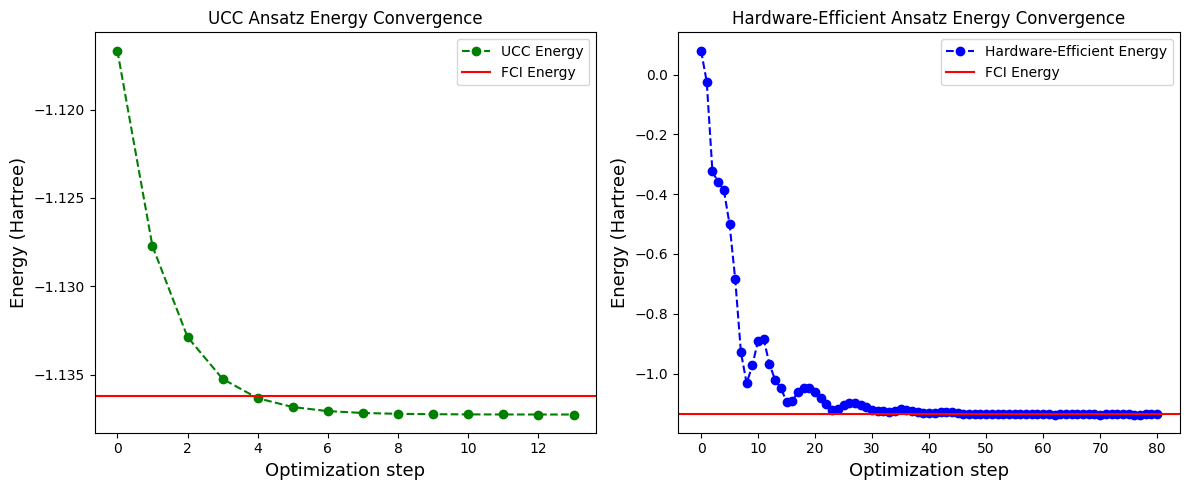

In [62]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))

# Plot UCC energy convergence
ax1 = fig.add_subplot(121)
ax1.plot(range(len(energy)), energy, "go", ls="dashed", label="UCC Energy")
ax1.axhline(E_fci, color="red", label="FCI Energy")
ax1.set_xlabel("Optimization step", fontsize=13)
ax1.set_ylabel("Energy (Hartree)", fontsize=13)
ax1.legend()
ax1.set_title("UCC Ansatz Energy Convergence")

# Plot Hardware-Efficient Ansatz energy convergence
ax2 = fig.add_subplot(122)
ax2.plot(range(len(cost_history)), cost_history, "bo", ls="dashed", label="Hardware-Efficient Energy")
ax2.axhline(E_fci, color="red", label="FCI Energy")
ax2.set_xlabel("Optimization step", fontsize=13)
ax2.set_ylabel("Energy (Hartree)", fontsize=13)
ax2.legend()
ax2.set_title("Hardware-Efficient Ansatz Energy Convergence")

plt.tight_layout()
plt.show()

In [7]:
def hardware_efficient_ansatz(params, wires):
    """
    A simple hardware-efficient ansatz.
    """
    num_layers = params.shape[0]
    num_qubits = len(wires)

    for layer in range(num_layers):
        for i in range(num_qubits):
            qml.U3(params[layer, i, 0], params[layer, i, 1], params[layer, i, 2], wires=i)
        for i in range(num_qubits - 1):
            qml.CNOT(wires=[i, i + 1])

def calculate_gradient_variance(num_qubits, num_layers, num_samples=100):
    """
    Calculates the variance of a gradient component for a randomly
    initialized circuit.

    Args:
        num_qubits (int): The number of qubits in the circuit.
        num_layers (int): The number of layers in the ansatz.
        num_samples (int): The number of random initializations to average over.

    Returns:
        float: The variance of the gradient of the first parameter.
    """
    dev = qml.device("default.qubit", wires=num_qubits)

    # We define a simple cost function: the expectation value of PauliZ on the first qubit.
    # This is a "local" cost function. The effect is even stronger for "global" cost functions.
    @qml.qnode(dev)
    def circuit(params):
        hardware_efficient_ansatz(params, wires=range(num_qubits))
        return qml.expval(qml.PauliZ(0))

    # We will calculate the gradient with respect to the first parameter
    grad_fn = qml.grad(circuit)
    
    gradients = []
    for _ in range(num_samples):
        # Initialize with new random parameters for each sample
        params1 = np.arccos(1.0 - 2 * np.random.rand(num_layers, num_qubits))
        params2 = 2 * np.pi * np.random.rand(num_layers, num_qubits)
        params3 = 2 * np.pi * np.random.rand(num_layers, num_qubits)
        params = np.stack([params1, params2, params3], axis=2)
        
        # Calculate the gradient for this initialization
        gradient = grad_fn(params)
        
        # We only care about the gradient of the first parameter
        gradients.append(gradient[0, 0])
        
    return np.var(gradients)

In [8]:
# --- Main part of the script ---
print("Calculating gradient variance for different numbers of qubits and layers...")
print("This may take a moment...")

# We will test for a range of circuit depths and qubit numbers
layer_range = range(1, 20, 2)
qubit_range = [4, 6, 8, 10] # Test circuits with different widths
results = {qubits: [] for qubits in qubit_range}

for n_qubits in qubit_range:
    print(f"\n--- Running for {n_qubits} qubits ---")
    for num_layers in layer_range:
        print(f"  Running for {num_layers} layers...")
        var = calculate_gradient_variance(n_qubits, num_layers, num_samples=50) # Reduced samples for speed
        results[n_qubits].append(var)

Calculating gradient variance for different numbers of qubits and layers...
This may take a moment...

--- Running for 4 qubits ---
  Running for 1 layers...
  Running for 3 layers...
  Running for 5 layers...
  Running for 7 layers...
  Running for 9 layers...
  Running for 11 layers...
  Running for 13 layers...
  Running for 15 layers...
  Running for 17 layers...
  Running for 19 layers...

--- Running for 6 qubits ---
  Running for 1 layers...
  Running for 3 layers...
  Running for 5 layers...
  Running for 7 layers...
  Running for 9 layers...
  Running for 11 layers...
  Running for 13 layers...
  Running for 15 layers...
  Running for 17 layers...
  Running for 19 layers...

--- Running for 8 qubits ---
  Running for 1 layers...
  Running for 3 layers...
  Running for 5 layers...
  Running for 7 layers...
  Running for 9 layers...
  Running for 11 layers...
  Running for 13 layers...
  Running for 15 layers...
  Running for 17 layers...
  Running for 19 layers...

--- Running 

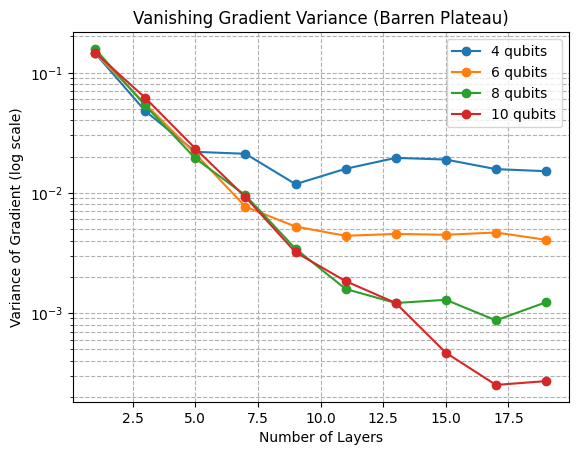

In [11]:
# --- Plotting the results ---
fig, ax = plt.subplots()
for n_qubits, variances in results.items():
    ax.plot(list(layer_range), variances, 'o-', label=f'{n_qubits} qubits')

ax.set_yscale('log') # Use a log scale to see the exponential decay
ax.set_title("Vanishing Gradient Variance (Barren Plateau)")
ax.set_xlabel("Number of Layers")
ax.set_ylabel("Variance of Gradient (log scale)")
ax.grid(True, which="both", ls="--")
ax.legend()
plt.show()